This script computes the climatic fragility considering these aspects:
- Percentage of area with nature-based green solutions (such as public parks, urban forests, street trees... )
- Percentage of area with blue nature-based solutions (ponds, lakes, rivers...)
- Climate shelters score (if any)
- Percentage of heat island

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 62.9 MB/s eta 0:00:00


In [3]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 93.8 MB/s eta 0:00:00


### 0. Libraries

In [4]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import numpy as np
import rasterstats
from rasterstats import zonal_stats
from matplotlib import pyplot as plt


### 1. Indicator for Climate fragility
Select only fully covered statistical areas

In [6]:
# Load the shapefile containing the statistical areas of Comune di Bologna
#areas_gdf = gpd.read_file(r"D:\Meteoblue\aree-statistiche.shp")
areas_gdf = gpd.read_file(r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Meteoblue/aree-statistiche.shp")

In [8]:
# Open the TIFF file
with rasterio.open(r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Meteoblue/Air_temperature_Bologna/Estati_22_23/reprojected_bologna/reprojected_bologna_2022060116Z.tif") as src:   # file of meteoblue about temperature
 # Get the bounds of the raster
    raster_bounds = src.bounds

    # Create a bounding box polygon from the raster bounds
    raster_box = box(raster_bounds.left, raster_bounds.bottom, raster_bounds.right, raster_bounds.top)

    # Check if each area is fully contained within the raster's bounding box
    fully_covered_mask = areas_gdf.geometry.within(raster_box)


In [9]:
# Filter the areas GeoDataFrame to include only fully covered areas
fully_covered_areas_gdf = areas_gdf[fully_covered_mask]

<Axes: >

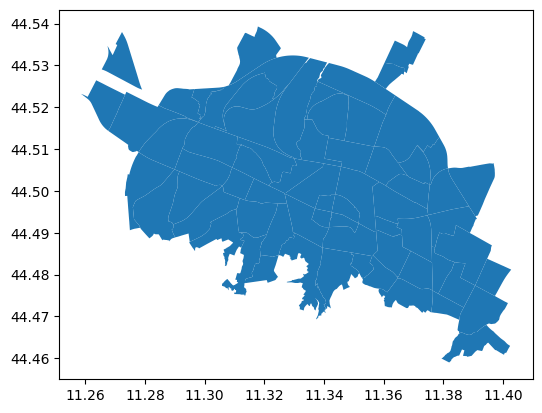

In [10]:
fully_covered_areas_gdf.plot()

In [11]:
print(list(fully_covered_areas_gdf['area_statis']))

['TRIUMVIRATO-PIETRA', 'CASTELDEBOLE', 'BATTINDARNO', 'LUNGO RENO', 'OSPEDALE BELLARIA', 'MEZZOFANTI', 'PESCAROLA', 'BEVERARA', 'MALPIGHI-1', 'STADIO-MELONCELLO', 'CASERME ROSSE-MANIFATTURA', 'CNR', 'ARCOVEGGIO', 'VIA FERRARESE', "PIAZZA DELL'UNITA'", 'BARGELLINO', 'EMILIA PONENTE', "OSPEDALE SANT'ORSOLA", 'MENGOLI', 'GUELFA', 'PRATI DI CAPRARA-OSPEDALE MAGGIORE', 'SCALO RAVONE', 'VIA VITTORIO VENETO', 'AGUCCHI', 'VIA DEL LAVORO', 'FOSSOLO', 'PONTEVECCHIO', 'GALVANI-1', 'GALVANI-2', 'DUCATI-VILLAGGIO INA', 'BORGO CENTRO', 'MULINO DEL GOMITO', 'OSSERVANZA', 'VILLAGGIO DELLA BARCA', 'SAN MICHELE IN BOSCO', 'GIARDINI MARGHERITA', 'LAZZARETTO', 'CANALE DI RENO', 'VIA ARNO', 'CIRENAICA', 'LA DOZZA', 'SAN GIUSEPPE', 'VIA DEL GENIO', 'VELODROMO', 'MICHELINO', 'VIA MONDO', 'IRNERIO-1', 'MARCONI-2', 'LA BIRRA', 'SIEPELUNGA', 'DAGNINI', 'MALPIGHI-2', 'CHIESANUOVA', 'XXI APRILE', 'EX MERCATO ORTOFRUTTICOLO', 'SCANDELLARA', 'VIA LARGA', 'MARCONI-1', 'RAVONE', 'ZANARDI', 'SAN DONNINO', 'DUE MADONNE

In [12]:
fully_covered_areas_gdf.shape

(68, 7)

In [ ]:
# Save the fully covered areas to a new shapefile
fully_covered_areas_gdf.to_file(r"/data/Climate Shelter_Talia/climate-shelters_2025/data/Meteoblue/covered_areas.shp")

#### 1.1 Percentage of Green nature-based solutions

In [13]:
# Load shapefiles
covered_areas = gpd.read_file(r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Meteoblue/covered_areas.shp")   # statistical areas of bologna
green = gpd.read_file(r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Bologna_DBSN/Bologna_dbsn_selected/Unione_all_gree_area.shp")  # green areas of bologna


In [14]:
# Check crs
if covered_areas.crs != green.crs:
    raise ValueError('different crs!')

In [15]:
covered_areas['green%'] = covered_areas.geometry.apply(lambda x: (x.intersection(green.unary_union).area / x.area) * 100)

/tmp/ipython-input-1236085594.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  covered_areas['green%'] = covered_areas.geometry.apply(lambda x: (x.intersection(green.unary_union).area / x.area) * 100)


In [16]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,geometry,green%
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,...",64.106510
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",57.784692
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,"POLYGON ((11.30337 44.50128, 11.30366 44.50117...",54.386370
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,"POLYGON ((11.30661 44.52489, 11.30653 44.52477...",65.579211
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,"POLYGON ((11.39674 44.46646, 11.39726 44.46607...",63.030694


In [18]:
# Save the result
#covered_areas.to_file("D:/Climatic_fragility/green_percentage.shp")
covered_areas.to_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/green_percentage.shp")

#### 1.2 Percentage of Blue nature-based solutions

In [19]:
# Load shapefiles
covered_areas = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/green_blue_percentage.shp")   # statistical areas of bologna + percentage of green
blue = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/idrografia/all_blue_area.shp")  # blue areas of bologna

In [20]:
# Check crs
if covered_areas.crs != blue.crs:
    raise ValueError('different crs!')

In [21]:
covered_areas['blue%'] = covered_areas.geometry.apply(lambda x: (x.intersection(blue.unary_union).area / x.area) * 100)

/tmp/ipython-input-488360097.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  covered_areas['blue%'] = covered_areas.geometry.apply(lambda x: (x.intersection(blue.unary_union).area / x.area) * 100)


In [22]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,geometry
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,..."
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,"POLYGON ((11.28826 44.50371, 11.28808 44.50357..."
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,54.386370,0.000000,"POLYGON ((11.30337 44.50128, 11.30366 44.50117..."
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,65.579211,8.792652,"POLYGON ((11.30661 44.52489, 11.30653 44.52477..."
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,63.030694,0.649383,"POLYGON ((11.39674 44.46646, 11.39726 44.46607..."


In [23]:
#covered_areas.to_file("D:/Climatic_fragility/green_blue_percentage.shp")
covered_areas.to_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/green_blue_percentage.shp")

#### 1.3 Number of Climate Shelters and their scores


In [24]:
# Load shapefiles
covered_areas = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/green_blue_percentage.shp")   # statistical areas of bologna + blue and green percentage
climate_shelters = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climate_Shelter_Index/isocrona/CSI/CSI.shp")

In [25]:
# Spatially join the two shapefiles to count the number of climatic refuges in each statistical area
joined = gpd.sjoin(covered_areas, climate_shelters, how="left", predicate="contains")

In [27]:
# Group by the statistical areas and count the number of refuges in each area
cs_counts = joined.groupby('codice_are')['CSI'].count().reset_index(name='CS')

In [26]:
# Group by the statistical areas and calculate the average 'CSI' score for refuges in each area
cs_avg = joined.groupby('codice_are')['CSI'].mean().reset_index()

In [28]:
# Fill NaN values with 0
cs_avg['CSI'].fillna(0, inplace=True)

/tmp/ipython-input-2822068799.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cs_avg['CSI'].fillna(0, inplace=True)


In [29]:
# Merge the 'CS' counts back into covered_areas based on the statistical area
covered_areas = covered_areas.merge(cs_counts, on='codice_are', how='left')

In [30]:
# Merge the 'CSI' averages back into covered_areas based on the statistical area
covered_areas = covered_areas.merge(cs_avg, on='codice_are', how='left')

In [31]:
covered_areas.rename(columns={'CSI': 'CSI_avg'}, inplace=True)

In [32]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,geometry,CS,CSI_avg
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,...",16,0.116757
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",19,0.091588
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,54.386370,0.000000,"POLYGON ((11.30337 44.50128, 11.30366 44.50117...",28,0.068966
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,65.579211,8.792652,"POLYGON ((11.30661 44.52489, 11.30653 44.52477...",0,0.000000
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,63.030694,0.649383,"POLYGON ((11.39674 44.46646, 11.39726 44.46607...",3,0.076150


In [34]:
# Save shapefile
#covered_areas.to_file("D:/Climatic_fragility/g_b_csi.shp")
covered_areas.to_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/g_b_csi.shp")

#### 1.4 Percentage of Heat Island

# Air Temperature Processing (vector file)
##Skip if using LST

In [ ]:
# Load the shapefile
covered_areas = gpd.read_file("/data/Climate Shelter_Talia/climate-shelters_2025/data/Climatic_fragility/g_b_csi.shp")   # statistical areas of bologna
hot_cold_spots = gpd.read_file("D:/Meteoblue/Air_temperature_Bologna/Estati_22_23/Hot_Cold_Spot/hot_cold_spots_vector.shp")

In [ ]:
# Select hot and cold area
polygons_4 = hot_cold_spots[hot_cold_spots['DN'] == 4]
polygons_1 = hot_cold_spots[hot_cold_spots['DN'] == 1]

In [ ]:
covered_areas['hot_area%'] = covered_areas.geometry.apply(lambda x: (x.intersection(polygons_4.unary_union).area / x.area) * 100)

c:\Users\elima\anaconda3\envs\geoss\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
covered_areas['cold_area%'] = covered_areas.geometry.apply(lambda x: (x.intersection(polygons_1.unary_union).area / x.area) * 100)

c:\Users\elima\anaconda3\envs\geoss\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [ ]:
covered_areas.head()

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,geometry,hot_area%,cold_area%
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,16,0.116757,"POLYGON ((11.29699 44.51663, 11.29740 44.51652...",47.016418,0.000000
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,19,0.091588,"POLYGON ((11.28826 44.50371, 11.28808 44.50357...",41.735059,0.000000
2,37,BATTINDARNO,11,Borgo Panigale - Reno,A,Barca,54.386370,0.000000,28,0.068966,"POLYGON ((11.30337 44.50128, 11.30366 44.50117...",65.974661,0.000000
3,6,LUNGO RENO,11,Borgo Panigale - Reno,C,Borgo Panigale,65.579211,8.792652,0,0.000000,"POLYGON ((11.30661 44.52489, 11.30653 44.52477...",17.813553,0.336931
4,86,OSPEDALE BELLARIA,16,Savena,N,Mazzini,63.030694,0.649383,3,0.076150,"POLYGON ((11.39674 44.46646, 11.39726 44.46607...",0.500572,58.199828


In [ ]:
# Save shapefile
#covered_areas.to_file("D:/Climatic_fragility/g_b_csi_hot_cold.shp")

# LST Raster data processing

In [35]:
# Load polygons (statistical areas)
covered_areas = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/Climatic_fragility/g_b_csi.shp")

# Path to your ECOSTRESS classified raster (added step for LST raster)
lst_classified = "/data/Climate Shelter_Talea/climate-shelters_2025/data/LST2025/LST_hot_cold_classified.tif"

# Match CRS between polygons and raster
with rasterio.open(lst_classified) as src:
    raster_crs = src.crs
covered_areas = covered_areas.to_crs(raster_crs)

# Compute zonal stats
zs = zonal_stats(
    covered_areas,
    lst_classified,
    categorical=True,
    nodata=0
)

# Compute % of each class
hot_percentages = []
cold_percentages = []

for zone in zs:
    total = sum(zone.values())
    hot_percent = (zone.get(4, 0) / total) * 100 if total > 0 else 0
    cold_percent = (zone.get(1, 0) / total) * 100 if total > 0 else 0
    hot_percentages.append(hot_percent)
    cold_percentages.append(cold_percent)

covered_areas["hot_area%"] = hot_percentages
covered_areas["cold_area%"] = cold_percentages


In [36]:
covered_areas.to_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/indicators/g_b_csi_hot_cold_lst.shp")

In [37]:
covered_areas[["hot_area%", "cold_area%"]].describe()


,hot_area%,cold_area%
count,68.000000,68.000000
mean,15.501124,13.721714
std,11.101797,17.063390
min,0.000000,0.000000
25%,8.032144,1.642134
50%,13.527908,7.152486
75%,21.079426,21.696901
max,49.780725,88.916475


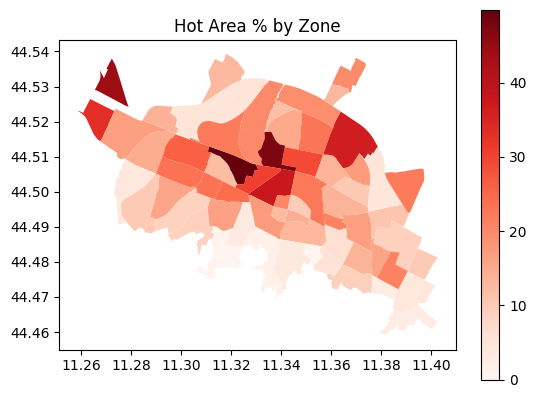

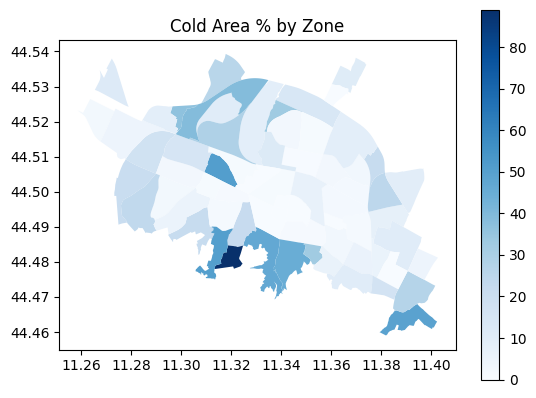

In [38]:
covered_areas.plot(column='hot_area%', cmap='Reds', legend=True)
plt.title('Hot Area % by Zone')
plt.show()

covered_areas.plot(column='cold_area%', cmap='Blues', legend=True)
plt.title('Cold Area % by Zone')
plt.show()


### 2. Climate Fragility

In [39]:
# load shapefile
#indicators = gpd.read_file("D:/Climatic_fragility/climate_fragility_index.shp")
#indicators = gpd.read_file("D:/Climatic_fragility/g_b_csi_hot_cold.shp") #airtemp
indicators = gpd.read_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/indicators/g_b_csi_hot_cold_lst.shp")  #LST

In [40]:
indicators.head(2)

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry
0,9,TRIUMVIRATO-PIETRA,11,Borgo Panigale - Reno,C,Borgo Panigale,64.106510,2.515611,16,0.116757,14.768695,17.491451,"POLYGON ((11.29699 44.51663, 11.2974 44.51652,..."
1,11,CASTELDEBOLE,11,Borgo Panigale - Reno,C,Borgo Panigale,57.784692,4.217511,19,0.091588,4.136334,21.164792,"POLYGON ((11.28826 44.50371, 11.28808 44.50357..."


In [41]:
# Normalize indicator
indicators_to_normalize = ['green%', 'blue%', 'hot_area%', 'cold_area%']
indicators[indicators_to_normalize] = indicators[indicators_to_normalize] / 100


In [42]:
# Calculate fragility index
indicators['fragility'] = 1 - ((indicators['green%'] + indicators['blue%'] + indicators['CSI_avg']
                                + indicators['cold_area%']) - indicators['hot_area%'])

In [43]:
indicators[indicators['codice_are']=='16']

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry,fragility
54,16,EX MERCATO ORTOFRUTTICOLO,12,Navile,B,Bolognina,0.280045,0.005404,4,0.267884,0.472547,0.119802,"POLYGON ((11.34588 44.50624, 11.34574 44.50578...",0.799412


In [44]:
# Identify min and max value of fragility
min_value = indicators['fragility'].min()
max_value = indicators['fragility'].max()

In [45]:
# Normalize the fragility index
indicators['Nfragility']= (indicators['fragility'] - min_value) / (max_value - min_value)

In [46]:
covered_areas_frag_sorted = indicators.sort_values(by='Nfragility', ascending=False).head(10)
covered_areas_frag_sorted

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry,fragility,Nfragility
21,32,SCALO RAVONE,13,Porto - Saragozza,P,Saffi,0.011894,0.000000,0,0.000000,0.497807,0.010375,"POLYGON ((11.31082 44.51116, 11.31083 44.51134...",1.475537,1.000000
47,29,MARCONI-2,13,Porto - Saragozza,M,Marconi,0.105116,0.000776,18,0.064213,0.377040,0.007594,"POLYGON ((11.3423 44.49899, 11.34225 44.49885,...",1.199340,0.881067
57,30,MARCONI-1,13,Porto - Saragozza,M,Marconi,0.006284,0.000000,1,0.038003,0.205835,0.000000,"POLYGON ((11.34378 44.49907, 11.3436 44.49847,...",1.161547,0.864793
27,53,GALVANI-1,15,Santo Stefano,G,Galvani,0.008865,0.000000,2,0.032603,0.144507,0.000000,"POLYGON ((11.34831 44.4935, 11.34883 44.49329,...",1.103039,0.839599
15,3,BARGELLINO,11,Borgo Panigale - Reno,C,Borgo Panigale,0.204183,0.008595,1,0.022638,0.442010,0.118019,"POLYGON ((11.27538 44.53243, 11.27548 44.5322,...",1.088576,0.833371
8,78,MALPIGHI-1,13,Porto - Saragozza,L,Malpighi,0.007724,0.000000,1,0.033492,0.123241,0.000000,"POLYGON ((11.34257 44.49361, 11.34232 44.49359...",1.082025,0.830550
17,66,OSPEDALE SANT'ORSOLA,14,San Donato - San Vitale,T,S. Vitale,0.139316,0.000000,0,0.000000,0.210947,0.003383,"POLYGON ((11.36421 44.49222, 11.3644 44.49221,...",1.068249,0.824618
46,60,IRNERIO-1,15,Santo Stefano,H,Irnerio,0.013632,0.000000,2,0.021053,0.095811,0.000000,"POLYGON ((11.35019 44.4961, 11.35034 44.49595,...",1.061126,0.821551
51,77,MALPIGHI-2,13,Porto - Saragozza,L,Malpighi,0.110786,0.000000,8,0.034905,0.174138,0.002311,"POLYGON ((11.32772 44.49906, 11.32935 44.49849...",1.026137,0.806484
29,7,DUCATI-VILLAGGIO INA,11,Borgo Panigale - Reno,C,Borgo Panigale,0.197723,0.000000,11,0.098641,0.334352,0.023946,"POLYGON ((11.27295 44.52234, 11.2726 44.52178,...",1.014042,0.801276


In [47]:
indicators[indicators['Nfragility']>0.8]

,codice_are,area_stati,cod_quar,quartiere,cod_zona,zona,green%,blue%,CS,CSI_avg,hot_area%,cold_area%,geometry,fragility,Nfragility
8,78,MALPIGHI-1,13,Porto - Saragozza,L,Malpighi,0.007724,0.000000,1,0.033492,0.123241,0.000000,"POLYGON ((11.34257 44.49361, 11.34232 44.49359...",1.082025,0.830550
15,3,BARGELLINO,11,Borgo Panigale - Reno,C,Borgo Panigale,0.204183,0.008595,1,0.022638,0.442010,0.118019,"POLYGON ((11.27538 44.53243, 11.27548 44.5322,...",1.088576,0.833371
17,66,OSPEDALE SANT'ORSOLA,14,San Donato - San Vitale,T,S. Vitale,0.139316,0.000000,0,0.000000,0.210947,0.003383,"POLYGON ((11.36421 44.49222, 11.3644 44.49221,...",1.068249,0.824618
21,32,SCALO RAVONE,13,Porto - Saragozza,P,Saffi,0.011894,0.000000,0,0.000000,0.497807,0.010375,"POLYGON ((11.31082 44.51116, 11.31083 44.51134...",1.475537,1.000000
27,53,GALVANI-1,15,Santo Stefano,G,Galvani,0.008865,0.000000,2,0.032603,0.144507,0.000000,"POLYGON ((11.34831 44.4935, 11.34883 44.49329,...",1.103039,0.839599
29,7,DUCATI-VILLAGGIO INA,11,Borgo Panigale - Reno,C,Borgo Panigale,0.197723,0.000000,11,0.098641,0.334352,0.023946,"POLYGON ((11.27295 44.52234, 11.2726 44.52178,...",1.014042,0.801276
46,60,IRNERIO-1,15,Santo Stefano,H,Irnerio,0.013632,0.000000,2,0.021053,0.095811,0.000000,"POLYGON ((11.35019 44.4961, 11.35034 44.49595,...",1.061126,0.821551
47,29,MARCONI-2,13,Porto - Saragozza,M,Marconi,0.105116,0.000776,18,0.064213,0.377040,0.007594,"POLYGON ((11.3423 44.49899, 11.34225 44.49885,...",1.199340,0.881067
51,77,MALPIGHI-2,13,Porto - Saragozza,L,Malpighi,0.110786,0.000000,8,0.034905,0.174138,0.002311,"POLYGON ((11.32772 44.49906, 11.32935 44.49849...",1.026137,0.806484
57,30,MARCONI-1,13,Porto - Saragozza,M,Marconi,0.006284,0.000000,1,0.038003,0.205835,0.000000,"POLYGON ((11.34378 44.49907, 11.3436 44.49847,...",1.161547,0.864793


In [49]:
# Save shapefile
#indicators.to_file("/data/Climate Shelter_Talia/climate-shelters_2025/data/Climatic_fragility/climate_fragility_index.shp") #for air temp
indicators.to_file("/data/Climate Shelter_Talea/climate-shelters_2025/data/indicators/climate_fragility_index_lst.shp")